# Examples of running HypoInvPy with utility functions
The original event catalog and phase picks are the output of the QuakeFlow and GAMMA codes.

In [1]:
import os, sys,glob
import pandas as pd
import numpy as np
from hypoinvpy import core as hc
from hypoinvpy import utils
import json
import matplotlib.pyplot as plt

## Convert station information from json database to CSV
The example here uses the *.json file saved by EQTransforer downloading step. The CSV file is for general purpose. To reformat it for HypoInverse code, please see the next example.

In [2]:
infile='input/GAMMA_station_list.json'
station_csv='input/GAMMA_station_list.csv'
utils.stainfo_json2csv(infile,informat='gamma',outfile=station_csv)
stainfo=utils.stainfo_json2csv(infile,informat='gamma')
print(stainfo)

   network station channel   latitude   longitude  elevation
0       AV    DEER     BHE  54.971270 -162.324370      392.3
1       AV    DEER     BHN  54.971270 -162.324370      392.3
2       AV    DEER     BHZ  54.971270 -162.324370      392.3
3       AV     DOL     BHE  55.149621 -161.864720      453.0
4       AV     DOL     BHN  55.149621 -161.864720      453.0
5       AV     DOL     BHZ  55.149621 -161.864720      453.0
6       AV     DT1     BHE  55.106270 -162.283130      198.0
7       AV     DT1     BHN  55.106270 -162.283130      198.0
8       AV     DT1     BHZ  55.106270 -162.283130      198.0
9       AV     DTN     BHE  55.144800 -162.259000      396.0
10      AV     DTN     BHN  55.144800 -162.259000      396.0
11      AV     DTN     BHZ  55.144800 -162.259000      396.0
12      AV     HAG     SHE  55.316860 -161.904390      515.4
13      AV     HAG     SHN  55.316860 -161.904390      515.4
14      AV     HAG     SHZ  55.316860 -161.904390      515.4
15      AV    PN7A     B

## Reformat station information for HypoInverse code.
The `HypoInvPy.core.reformat_stainfo()` function takes input in `json` or `csv` format. You can specify the format as `json-gamma` for json files from running the gamma workflow. See the source code or use `help()` to get detailed usage information of this function. 

* `force_channel_type` option is to force all channels to the specified type. This is because in some earthquake detection and association steps, the original channel types might be lost, making it impossible to link the phase data with station information.
* `rename_component_dict` option is to rename component names. This is needec when some components originally having 1 or 2 in the names. These original names sometimes are not kept through the earthquake detection and association steps.
* `ignore_component` option will ignore the component code and only saves the channel type, e.g., BH instead of BHZ.

In [3]:
station_ready='input/GAMMA_station_list_ready.sta'
hc.reformat_stainfo(infile,station_ready,informat='json-gamma',ignore_component=False)

## Convert the phase picks and catalog from GAMMA to Hypoinverse format
The outputs from running GAMMA contain picks and preliminary catalog, while the solutions of locations are poor. This block shows examples of converting or merging the picks and earthquake catalog to phase data format needed by Hypoinverse. We are using Y2000-compatible format here (https://ncedc.org/ftp/pub/doc/ncsn/shadow2000.pdf).

If `qc` is True, only events with both P and S picks will be saved. 
`default_component` here to address the issue that GAMMA picks only have two letters for the channels (only channel type). Use one letter code here to replace the empty component code. If the component code also exists, the `default_component` value will be ignored.


In [4]:
pickfile='GAMMA_picks.csv'
eventfile='GAMMA_catalog.csv'
phase_file='input/GAMMA_phases_ready.phs' #output file after conversion.

utils.conv_gamma(eventfile,pickfile,outfile=phase_file,qc=False,default_component='Z',v=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 3207.99it/s]

202109250000190355 1584161E1116    0
DEER AV  BHZ    4202109250000             4052 S 2    0.000001
DT1  AV  BHZ  P 0202109250000 3126                    6.93497383963404e-07
DTN  AV  BHZ    4202109250000             4050 S 2    0.000001
HAG  AV  SHZ    4202109250000             3280 S 2    0.000000
S12K AV  BHZ    4202109250000             4068 S 1    0.000001
-> Saved 6 phase picks. 
202109250139324855  252162E 846    0
PN7A AV  BHZ  P 1202109250139 4024                    1.7451359326514648e-06
PN7A AV  BHZ    4202109250139             4420 S 2    0.000002
PS1A AV  BHZ  P 0202109250139 3982                    1.2517081131591112e-06
PS1A AV  BHZ    4202109250139             4802 S 1    0.000001
PS4A AV  BHZ  P 0202109250139 3942                    2.4089233647828223e-06
PS4A AV  BHZ    4202109250139             4368 S 1    0.000002
PV6A AV  SHZ  P 2202109250139 4236                    2.0175046699932866e-07
PVV  AV  SHZ    4202109250139             4476 S 2    0.000001
-> Saved 9 pha

## Setup parameters for HypoInverse code
Major parameters to run the code are carried through with a container class named `HypoInvPy.core.HypoInvConfig()`. This class is simplified from the `config()` class in `Hypo-Interface-Py`. In `HypoInvPy`, I also reduced the number of metadata/parameters, to focus only on required key parameters.

Examples here use the phase information directly from the `EQTransformer` association step. The station information file has been reformated as shown in the previous cell. 

In [5]:
# modified from https://github.com/YijianZhou/Hypo-Interface-Py
station_file=station_ready
pmodel='input/velo_p_eg.cre'
smodel='input/velo_s_eg.cre'
lat_code='N'
lon_code='W'
depth_try_list=np.arange(0,20,1)
min_nsta=4 #minimum number of stations to relocate the earthquake. 4 is recommeneded as the minimum to get a reliable location.
keep_summary_files=False #keep intermediate summary files from each relocation run?
outputdir='output'

cfg = hc.HypoInvConfig(phase_file=phase_file,station_file=station_file,
                       pmodel=pmodel,smodel=smodel,min_nsta=min_nsta,
                      lat_code=lat_code,lon_code=lon_code,ztrlist=depth_try_list)
#file names for the final summary catalogs.
out_bad = '%s/%s_bad.csv'%(outputdir,cfg.run_tag)
out_good = '%s/%s_good.csv'%(outputdir,cfg.run_tag)

## Run hypoinverse through the interface
This is the key step to run hypoinverse. I kept the way Hypo-Interface-Py uses running the code on a series of initial depths. This list is specified as `ztrlist` in the configuration step above.

In [6]:
# 1. produce parameter files for each testing initial depth.
hypparfiledir='input'
hypparfilelist=hc.generate_parfile(cfg,hypparfiledir,outdir=outputdir,magline='MAG')

# 2. Run hypoinverse with all parameter files.
hc.run_hypoinv(hypparfilelist)

 HYPOINVERSE 2000 STARTING
6/2014 VERSION 1.40 (geoid depth possible)                            
 COMMAND?     33 STATIONS READ IN.
  FIND INPUT PHASE FILE TYPE & SET PHS(COP) & ARC(CAR) FORMATS
  INPUT IS A HYPOINVERSE ARCHIVE-2000 FILE, NO SHADOWS
  SETTING FORMATS COP 3, CAR 1
 *** DISTANCE & RESIDUAL WEIGHTING CANCELLED FOR EVENT: 2021  9 25  0  0
  SEQ ---DATE--- TIME REMARK -LAT-  --LON-  DEPTH  RMS PMAG  NUM  ERH  ERZ  ID
    1 2021- 9-25  0:00     - 55 22  162 23   0.00 1.72  0.0    5 12.3 99.0         1
    2 2021- 9-25  1:39     # 55  3  162  8   0.02 0.53  0.0    7  7.6  9.9         2
 *** 3 PHASES CANT SOLVE SEQUENCE NO.    3, ID NO.         3
 *** ABANDON EVENT WITH ONLY 3 READINGS:2021  9 25  1 58
    4 2021- 9-25  2:02     - 55 35  161 49   0.00 0.13  0.0    4  2.4 16.7         4
 *** DISTANCE & RESIDUAL WEIGHTING CANCELLED FOR EVENT: 2021  9 25  2 13
    5 2021- 9-25  2:13     - 55 21  162  4   0.00 0.21  0.0    4  3.3 21.1         5
 *** DISTANCE & RESIDUAL WEIGHTING 

## Extract inversion results based on quality
In `hc.merge_summary`, you can pass the original event catalog to retrieve the magnitude information. Otherwise, the function will extract the magnitude from the HypoInverse results.

In [7]:
print('converting output sum files')
summary_filelist=glob.glob('%s/%s-*.sum'%(outputdir,cfg.run_tag))

hc.merge_summary(summary_filelist,out_good,out_bad,lat_code,lon_code,mag_dict=eventfile)


converting output sum files
Earthquakes are saved in: output/hyp_good.csv and output/hyp_bad.csv for good and bad sources.


In [8]:
# remove intermidiate files
for fname in glob.glob('fort.*'): os.unlink(fname)
for fname in glob.glob('input/%s-*.hyp'%cfg.run_tag): os.unlink(fname)
if not keep_summary_files:
    for fname in glob.glob(outputdir+'/'+cfg.run_tag+'*.sum'): os.unlink(fname)

## Read and plot the earthquakes

In [9]:
quakes=pd.read_csv(out_good,header=None,names=["datetime","latitude","longitude","depth","magnitude","evid"])
print(quakes)

       datetime  latitude  longitude  depth  magnitude  evid
0  2.021093e+13   55.2442  -161.4437   27.2       1.16     1
1  2.021093e+13   55.2765  -161.8112   36.3       1.03     2
2  2.021093e+13   55.4670  -161.9987   11.7       0.81    10


## Plot earthquakes scaled by magnitude and colored by depth

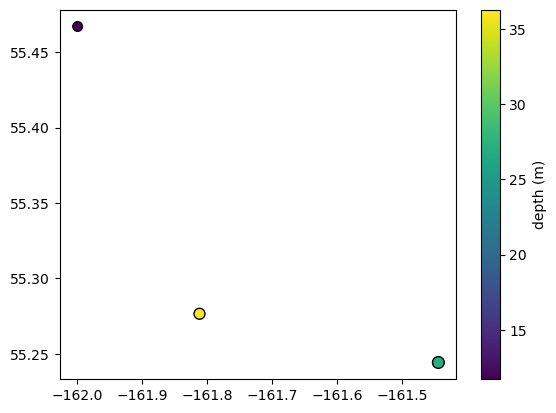

In [22]:
plt.scatter(quakes.longitude,quakes.latitude,20*np.power(3,quakes.magnitude),quakes.depth,edgecolors='k')
plt.colorbar(label='depth (km)')
plt.show()